# EMU and DES tile distribution and coverage

## Libraries

In [207]:
import pandas as pd

import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes.patches import Quadrangle
from astropy.wcs import WCS

import cartopy.crs as ccrs

from bs4 import BeautifulSoup

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon
import matplotlib.ticker as mticker

from shapely.geometry import Polygon as splyPolygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

import numpy as np

from collections import defaultdict

## Load EMU html file

In [166]:
# Load the HTML file

filename = '/home/polaris/Lab_Astro/data/EMU_data/EMU_tiles_full.html'
with open(filename, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table in the HTML (assuming there's only one table)
table = soup.find('table')

# Extract table headers (if any)
headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

# Extract table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    if len(cells) > 0:
        row = [cell.text.strip() for cell in cells]
        rows.append(row)

# Convert the table data into a pandas DataFrame
emu_tiles_df = pd.DataFrame(rows, columns=headers)

# Convert 'sbid' column to integer type
emu_tiles_df['sbid'] = pd.to_numeric(emu_tiles_df['sbid'], errors='coerce').astype('Int64')

# Convert 'obs_length' column to float type
emu_tiles_df['obs_length'] = pd.to_numeric(emu_tiles_df['obs_length'], errors='coerce').astype('float')

has_sbid = emu_tiles_df['sbid'].notna()

Convert the RA in hh:mm:ss and DEC in dd:mm:ss to degrees and save result sin new columns ra_deg; dec_deg

In [167]:
ra_hms = emu_tiles_df['ra'].values  # Extract RA values as a NumPy array
dec_dms = emu_tiles_df['dec'].values # Extract Dec values as a NumPy array

# Create a SkyCoord object directly from the arrays
emu_center_coords = SkyCoord(ra=ra_hms, dec=dec_dms, unit=(u.hourangle, u.deg))

# Create new columns in the data frame for the RA and DEC in degrees
emu_tiles_df['center_ra_deg'] = emu_center_coords.ra.deg
emu_tiles_df['center_dec_deg'] = emu_center_coords.dec.deg

# Create new columns in the data frame for the RA and DEC in degrees of the corners of each tile
# Size of the tile in degrees
size = 5 
half_size = size / 2

emu_tiles_df['rac1_deg'] = emu_tiles_df['center_ra_deg'] - half_size
emu_tiles_df['rac2_deg'] = emu_tiles_df['center_ra_deg'] + half_size
emu_tiles_df['rac3_deg'] = emu_tiles_df['center_ra_deg'] + half_size
emu_tiles_df['rac4_deg'] = emu_tiles_df['center_ra_deg'] - half_size

emu_tiles_df['decc1_deg'] = emu_tiles_df['center_dec_deg'] - half_size
emu_tiles_df['decc2_deg'] = emu_tiles_df['center_dec_deg'] - half_size
emu_tiles_df['decc3_deg'] = emu_tiles_df['center_dec_deg'] + half_size
emu_tiles_df['decc4_deg'] = emu_tiles_df['center_dec_deg'] + half_size

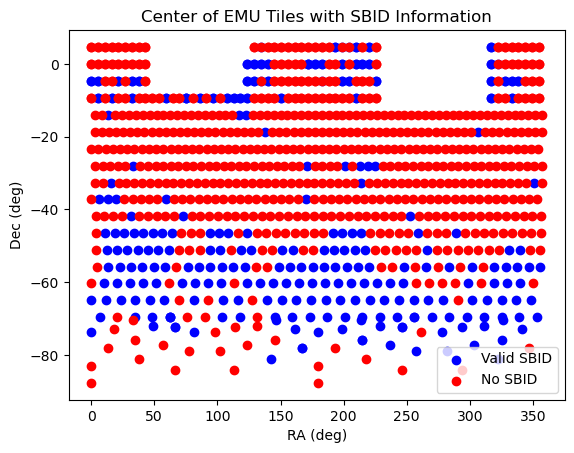

In [168]:
# Plot points with different colors based on whether 'sbid' is valid
plt.scatter(emu_tiles_df.loc[has_sbid, 'center_ra_deg'], emu_tiles_df.loc[has_sbid, 'center_dec_deg'], color='blue', label='Valid SBID')
plt.scatter(emu_tiles_df.loc[~has_sbid, 'center_ra_deg'], emu_tiles_df.loc[~has_sbid, 'center_dec_deg'], color='red', label='No SBID')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Center of EMU Tiles with SBID Information')
plt.legend()
plt.show()

## Plot the actual tiles around the centers for EMU

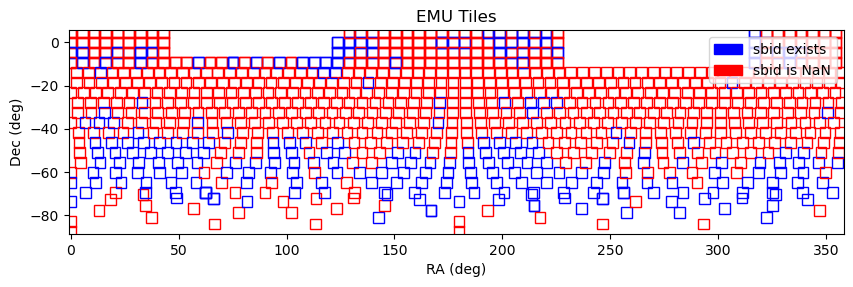

In [169]:
# WARNING: Need to run the code block above before running this code block

# Plot EMU tiles in degrees in flat square projection
plt.figure(figsize=(10, 8))
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    color = 'blue' if has_sbid[i] else 'red'
    tile = mplPolygon(corners_deg, closed=True, edgecolor=color, facecolor='none')

    plt.gca().add_patch(tile)

# Add legend
blue_patch = mpatches.Patch(color='blue', label='sbid exists')
red_patch = mpatches.Patch(color='red', label='sbid is NaN')
plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# Set plot labels and title
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('EMU Tiles')
plt.xlim(emu_tiles_df['center_ra_deg'].min() - 1, emu_tiles_df['center_ra_deg'].max() + 1)
plt.ylim(emu_tiles_df['center_dec_deg'].min() - 1, emu_tiles_df['center_dec_deg'].max() + 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

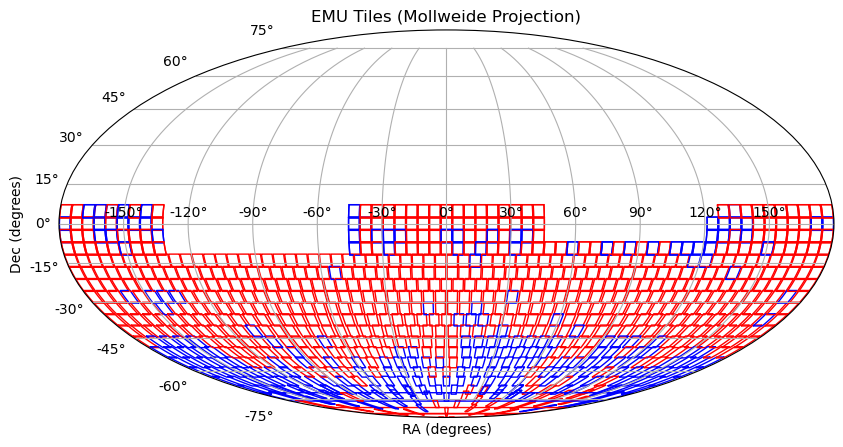

In [170]:
# Create a Mollweide projection plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot EMU tiles in radians in Mollweide projection
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    color = 'blue' if has_sbid[i] else 'red'
    tile = mplPolygon(corners_rad, closed=True, edgecolor=color, facecolor='none')

    plt.gca().add_patch(tile)

# Set plot labels and title
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('EMU Tiles (Mollweide Projection)')
ax.grid(True)

# Show the plot
plt.show()

## Plot the DES DR1 tiles

In [171]:
des_tiles_path = '/home/polaris/Lab_Astro/data/des_dr1.tile_info.fits'

# Create a data frame for the DES tiles (makes it more acessible)
with fits.open(des_tiles_path) as hdul:
    des_tiles_data = hdul[1].data

des_tiles_df = pd.DataFrame(des_tiles_data)


In [172]:
# Create a SkyCoord object for the center of the DES tiles
des_center_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Create a list of the field name and the correspondy SkyCoord object of the center of the field
des_tiles_dic = [[des_tiles_df['tilename'][i], des_center_coords[i]] for i in range(len(emu_tiles_df))]

In [173]:
# WARNING: Takes a while to run
# # Create a Mollweide projection plot
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='mollweide')

# # Plot EMU tiles in radians in Mollweide projection
# for i in range(len(des_tiles_plot_rad)):
#     plt.gca().add_patch(des_tiles_plot_rad[i])

# # Set plot labels and title
# ax.set_xlabel('RA (radians)')
# ax.set_ylabel('Dec (radians)')
# ax.set_title('DES DR1 Tiles (Mollweide Projection)')
# ax.grid(True)

# # Show the plot
# plt.show()

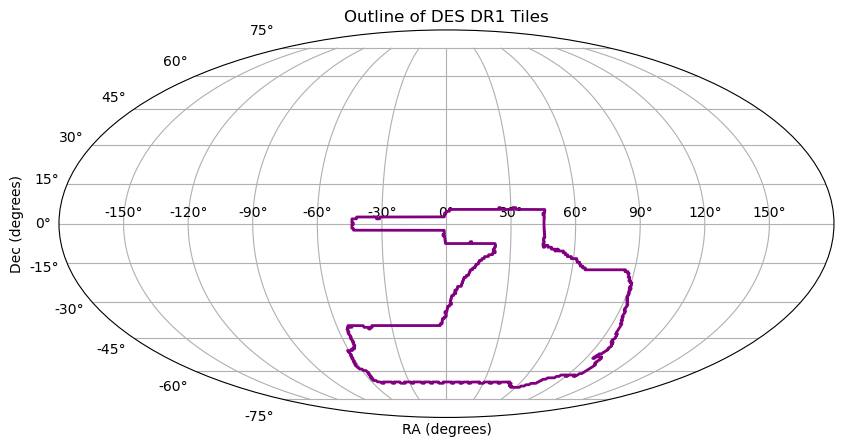

In [174]:
des_tiles_rad = []
for i in range(len(des_tiles_df)):

    corners_deg = [
        (des_tiles_df['rac1'][i],des_tiles_df['decc1'][i]),
        (des_tiles_df['rac2'][i],des_tiles_df['decc2'][i]),
        (des_tiles_df['rac3'][i],des_tiles_df['decc3'][i]),
        (des_tiles_df['rac4'][i],des_tiles_df['decc4'][i])
    ]

    # Shift RA values to center the plot at RA = 0 and convert to radians
    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]
    des_tiles_rad.append(splyPolygon(corners_rad))

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles')
ax.grid(True)

plt.show()

## Check for overlap of the DES tiles on EMU

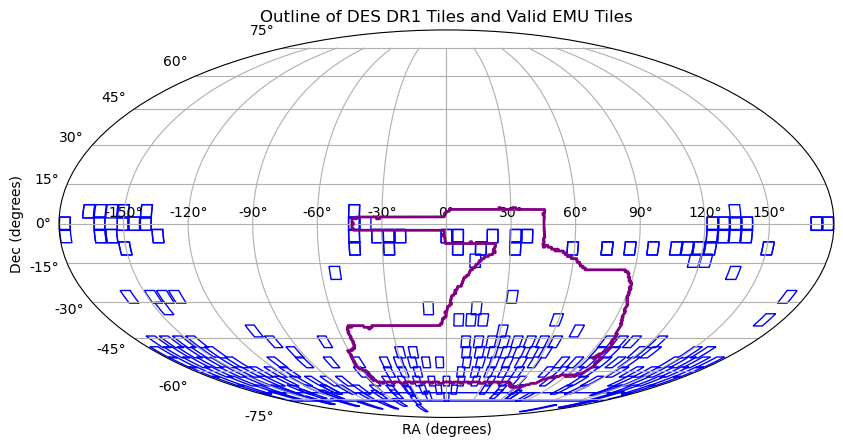

In [175]:
# Plot the outline of the DES DR1 tiles and valid EMU tiles

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    if has_sbid[i]:
        tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(tile)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()


Number of EMU candidates: 131


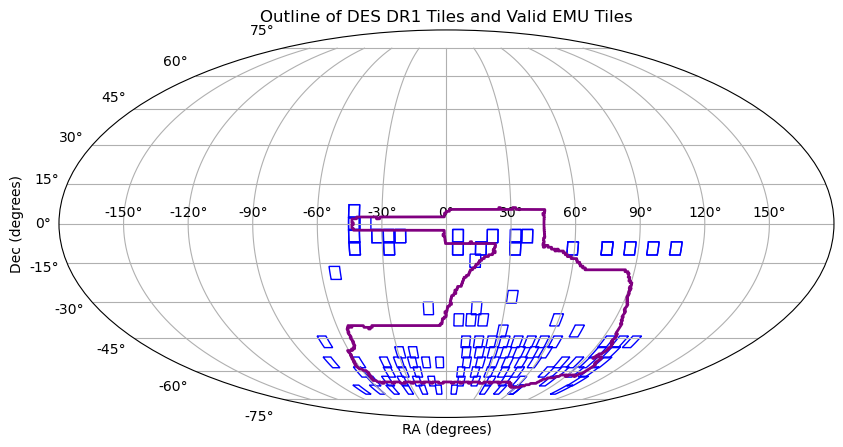

In [198]:
# Aproximated borders of DES DR1
ra_min1 = 0
ra_max1 = 110

ra_min2 = 280

dec_min = -70.0
dec_max = 10.0

# Find EMU tiles that are within the aproximated DES DR1 borders
emu_tiles_candidates = []

for i in range(len(emu_tiles_df['field_name'])):
    if has_sbid[i]:
        if ((emu_tiles_df['center_ra_deg'][i] > ra_min1 and emu_tiles_df['center_ra_deg'][i] < ra_max1) or (emu_tiles_df['center_ra_deg'][i] > ra_min2)) and emu_tiles_df['center_dec_deg'][i] > dec_min and emu_tiles_df['center_dec_deg'][i] < dec_max:
            emu_tiles_candidates.append(emu_tiles_df['field_name'][i])

print(f'Number of EMU candidates: {len(emu_tiles_candidates)}')

# Plot the outline of the DES DR1 tiles and candidates EMU tiles
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for field_name in emu_tiles_candidates:
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == field_name][0]

    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [( np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(tile)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()

In [ ]:
# OLD CODE, DO NOT RUN, TOO SLOW
# # Check if the DES DR1 tiles are within the EMU tiles
# emu_and_des = defaultdict(list)

# # Iterate through all EMU tiles
# for k in range(len(emu_tiles_candidates)):
#     emu_field_name = emu_tiles_candidates[k]    
#     i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]
    
#     # Get the center of the EMU tile as a SkyCoord object
#     center_tile = SkyCoord(
#         ra=emu_tiles_df['center_ra_deg'][i],
#         dec=emu_tiles_df['center_dec_deg'][i],
#         unit=(u.deg, u.deg)
#     )

#     # Loop through DES tiles to check for overlap
#     for j in range(len(des_center_coords)):
#         # Check Dec range
#         if (
#             des_center_coords[j].dec.deg < ((emu_tiles_df['center_dec_deg'][i] + 3) if (emu_tiles_df['center_dec_deg'][i] + 3)<360 else (emu_tiles_df['center_dec_deg'][i] + 3 - 360))
#             and des_center_coords[j].dec.deg > ((emu_tiles_df['center_dec_deg'][i] - 3) if (emu_tiles_df['center_dec_deg'][i] - 3)>0 else (emu_tiles_df['center_dec_deg'][i] - 3 + 360))
#         ):
#             if (
#                 des_center_coords[j].ra.deg < emu_tiles_df['center_ra_deg'][i] + 3
#                 and des_center_coords[j].ra.deg > emu_tiles_df['center_ra_deg'][i] - 3
#                 ):
#                     if center_tile.separation(des_center_coords[j]) < 3 * u.deg:
#                         emu_and_des[emu_field_name].append(des_tiles_df['tilename'][j])

#     print(emu_field_name)

# # Print the result
# print(emu_and_des)

EMU_0021-04A
EMU_0021-04B
EMU_0021-09A
EMU_0021-09B
EMU_0026-37
EMU_0027-69
EMU_0041-60
EMU_0044-46
EMU_0046-64
EMU_0049-51
EMU_0052-37
EMU_0054-14
EMU_0054-55
EMU_0102-32
EMU_0104-09A
EMU_0104-09B
EMU_0114-46
EMU_0118-37
EMU_0121-51
EMU_0122-60
EMU_0125-04A
EMU_0125-04B
EMU_0130-55
EMU_0132-64
EMU_0144-46
EMU_0154-51
EMU_0203-60
EMU_0204-41
EMU_0205-55
EMU_0208-04A
EMU_0208-04B
EMU_0208-09A
EMU_0208-09B
EMU_0212-28
EMU_0214-46
EMU_0218-69
EMU_0219-64
EMU_0227-51
EMU_0230-04A
EMU_0230-04B
EMU_0242-55
EMU_0244-46
EMU_0244-60
EMU_0259-51
EMU_0305-64
EMU_0313-69
EMU_0314-46
EMU_0317-55
EMU_0325-60
EMU_0332-51
EMU_0344-46
EMU_0352-64
EMU_0354-55
EMU_0355-37
EMU_0356-09A
EMU_0356-09B
EMU_0405-51
EMU_0409-69
EMU_0409-69
EMU_0409-69
EMU_0414-46


KeyboardInterrupt: 

In [224]:
# Precompute SkyCoord objects for EMU and DES tiles
emu_coords = SkyCoord(ra=emu_tiles_df['center_ra_deg'], dec=emu_tiles_df['center_dec_deg'], unit=(u.deg, u.deg))
des_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Define the search radius in degrees
search_radius = 4 * u.deg

# Initialize the result dictionary
emu_and_des = defaultdict(list)

# Iterate through all EMU tiles
for k, emu_field_name in enumerate(emu_tiles_candidates):
    # Get the index of the current EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]

    # Get the SkyCoord object for the current EMU tile
    center_tile = emu_coords[i]

    # Filter DES tiles based on RA and Dec ranges
    ra_diff = np.abs(des_coords.ra.deg - center_tile.ra.deg)
    ra_diff = np.minimum(ra_diff, 360 - ra_diff)  # Handle RA wrapping
    dec_diff = np.abs(des_coords.dec.deg - center_tile.dec.deg)

    # Apply the RA and Dec range filters
    mask = (ra_diff <= search_radius.value) & (dec_diff <= search_radius.value)

    # Further filter by actual angular separation
    close_des_tiles = des_coords[mask]
    separations = center_tile.separation(close_des_tiles)
    within_radius = separations < search_radius

    # Add matching DES tiles to the result
    matching_des_indices = np.where(mask)[0][within_radius]
    emu_and_des[emu_field_name] = des_tiles_df['tilename'].iloc[matching_des_indices].tolist()

    # Print progress
    print(f"Processed EMU Field: {emu_field_name}")

# Print the final result
print(emu_and_des)

Processed EMU Field: EMU_0021-04A
Processed EMU Field: EMU_0021-04B
Processed EMU Field: EMU_0021-09A
Processed EMU Field: EMU_0021-09B
Processed EMU Field: EMU_0026-37
Processed EMU Field: EMU_0027-69
Processed EMU Field: EMU_0041-60
Processed EMU Field: EMU_0044-46
Processed EMU Field: EMU_0046-64
Processed EMU Field: EMU_0049-51
Processed EMU Field: EMU_0052-37
Processed EMU Field: EMU_0054-14
Processed EMU Field: EMU_0054-55
Processed EMU Field: EMU_0102-32
Processed EMU Field: EMU_0104-09A
Processed EMU Field: EMU_0104-09B
Processed EMU Field: EMU_0114-46
Processed EMU Field: EMU_0118-37
Processed EMU Field: EMU_0121-51
Processed EMU Field: EMU_0122-60
Processed EMU Field: EMU_0125-04A
Processed EMU Field: EMU_0125-04B
Processed EMU Field: EMU_0130-55
Processed EMU Field: EMU_0132-64
Processed EMU Field: EMU_0144-46
Processed EMU Field: EMU_0154-51
Processed EMU Field: EMU_0203-60
Processed EMU Field: EMU_0204-41
Processed EMU Field: EMU_0205-55
Processed EMU Field: EMU_0208-04A
P

In [252]:
def plot_intersect(emu_field_name, des_tile_list):
    # Find the index of the EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]
    
    # Get the center of the EMU tile
    emu_ra_center = emu_tiles_df['center_ra_deg'][i]
    emu_dec_center = emu_tiles_df['center_dec_deg'][i]

    # Define the zoom range (e.g., ±10 degrees around the EMU tile center)
    ra_min_deg = emu_ra_center - 10
    ra_max_deg = emu_ra_center + 10
    dec_min_deg = emu_dec_center - 10
    dec_max_deg = emu_dec_center + 10

    # Create a Cartopy plot with Mollweide projection
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # Plot the EMU tile
    emu_corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    # Convert corners to radians for Mollweide projection
    emu_corners_rad = [(np.radians(ra - 360 if ra > 180 else ra), np.radians(dec)) for ra, dec in emu_corners_deg]

    # Convert corners to Cartopy format and plot
    emu_polygon = mplPolygon(emu_corners_rad, closed=True, edgecolor='blue', facecolor='none')
    ax.add_patch(emu_polygon)

    # Plot the DES tiles
    for des_tile_name in des_tile_list:
        j = des_tiles_df.index[des_tiles_df['tilename'] == des_tile_name][0]

        des_corners_deg = [
            (des_tiles_df['rac1'][j], des_tiles_df['decc1'][j]),
            (des_tiles_df['rac2'][j], des_tiles_df['decc2'][j]),
            (des_tiles_df['rac3'][j], des_tiles_df['decc3'][j]),
            (des_tiles_df['rac4'][j], des_tiles_df['decc4'][j])
        ]

        # Convert corners to radians for Mollweide projection
        des_corners_rad = [(np.radians(ra - 360 if ra > 180 else ra), np.radians(dec)) for ra, dec in des_corners_deg]

        # Convert corners to Cartopy format and plot
        des_polygon = mplPolygon(des_corners_rad, closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(des_polygon)

    # Set the extent (zoom in) using degrees
    ra_min_rad = np.radians(ra_min_deg - 360 if ra_min_deg > 180 else ra_min_deg)
    ra_max_rad = np.radians(ra_max_deg - 360 if ra_max_deg > 180 else ra_max_deg)
    dec_min_rad = np.radians(dec_min_deg)
    dec_max_rad = np.radians(dec_max_deg)

    ax.set_xlim(ra_min_rad, ra_max_rad)
    ax.set_ylim(dec_min_rad, dec_max_rad)

    # Add gridlines with custom labels in degrees
    gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.5)

    # Set plot title
    ax.set_title(f'EMU and DES Tiles (Zoomed-In on {emu_field_name})', fontsize=14)

    # Show the plot
    plt.show()

EMU Field: EMU_0344-46
DES Tiles: ['DES0336-4249', 'DES0340-4249', 'DES0345-4748', 'DES0349-4748', 'DES0354-4748', 'DES0358-4748', 'DES0334-4623', 'DES0338-4623', 'DES0343-4623', 'DES0347-4623', 'DES0351-4623', 'DES0355-4623', 'DES0359-4623', 'DES0332-4748', 'DES0357-4414', 'DES0352-4540', 'DES0331-4914', 'DES0337-4706', 'DES0342-4706', 'DES0330-4414', 'DES0332-4457', 'DES0336-4457', 'DES0334-4414', 'DES0338-4414', 'DES0342-4414', 'DES0340-4457', 'DES0344-4457', 'DES0348-4457', 'DES0346-4414', 'DES0350-4414', 'DES0354-4414', 'DES0353-4457', 'DES0357-4457', 'DES0329-4706', 'DES0333-4706', 'DES0331-4540', 'DES0334-4957', 'DES0339-4957', 'DES0343-4957', 'DES0331-4831', 'DES0336-4831', 'DES0340-4831', 'DES0344-4831', 'DES0337-4748', 'DES0341-4748', 'DES0348-4957', 'DES0349-4831', 'DES0353-4831', 'DES0352-4957', 'DES0356-4957', 'DES0347-4331', 'DES0351-4331', 'DES0355-4331', 'DES0358-4331', 'DES0357-4831', 'DES0331-4331', 'DES0335-4331', 'DES0339-4331', 'DES0356-4540', 'DES0400-4540', 'DES0

AttributeError: 'Axes' object has no attribute 'gridlines'

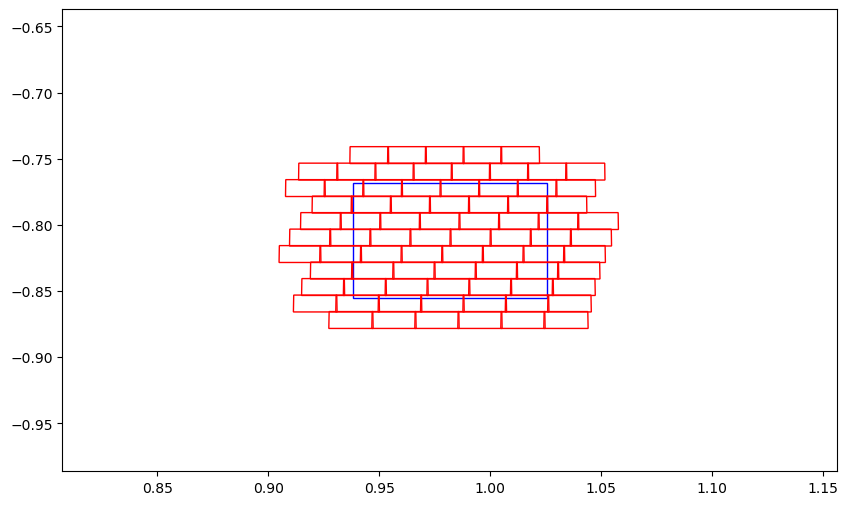

In [254]:
emu_field, des_tiles = list(emu_and_des.items())[50]
print(f'EMU Field: {emu_field}')
print(f'DES Tiles: {des_tiles}')

plot_intersect(emu_field, des_tiles)